# Chapter 13. Adventures in covariance

## Preamble

In [4]:
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.glm import GLM
import arviz as az
import rethinking
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import theano as tt
import warnings

In [5]:
plt.rcParams["figure.figsize"] = (20, 10)
warnings.filterwarnings("ignore", category=FutureWarning)   

## Chapter notes

### Cross-classified chimpanzees with varying slopes

In [48]:
df = pd.read_csv("../external/rethinking/data/chimpanzees.csv", sep=";")
print(f"Data contains {len(df)} samples")
df.head()

Data contains 504 samples


,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


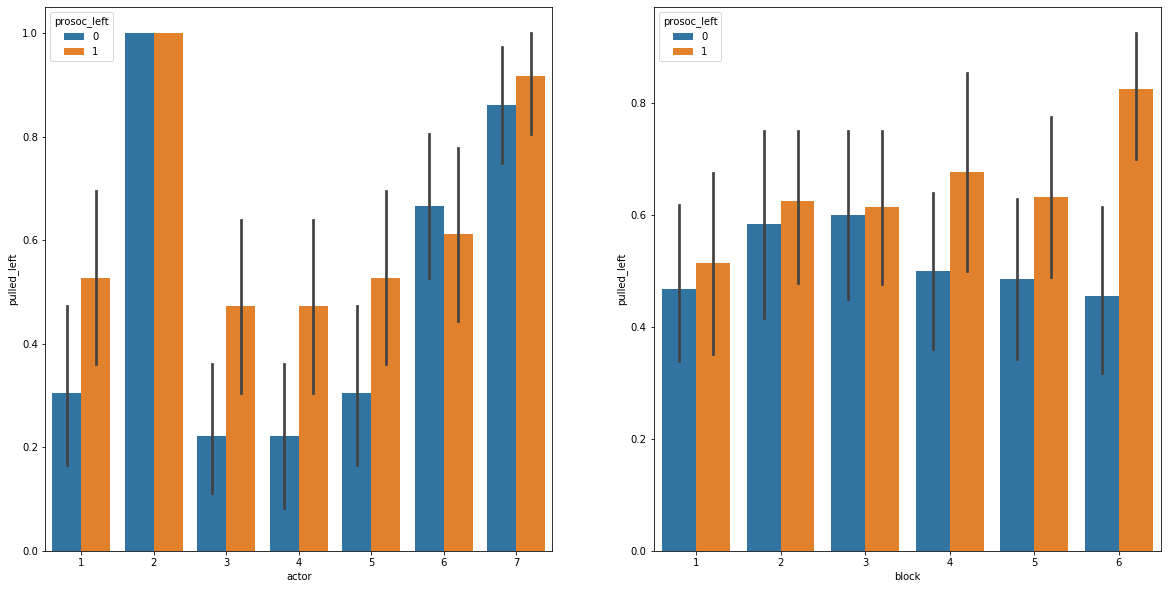

In [52]:
_, ax = plt.subplots(1, 2)
sns.barplot(x="actor", y="pulled_left", hue="prosoc_left", data=df, ax=ax[0]);
sns.barplot(x="block", y="pulled_left", hue="prosoc_left", data=df, ax=ax[1]);

In [65]:
models = {}
traces = {}

In [75]:
# The code produces a warning that is likely related to this open issue for Theano:
# https://github.com/Theano/Theano/issues/6667

actor = df.actor.values - 1
block = df.block.values - 1
condition = df.condition.values
prosoc_left = df.prosoc_left.values
pulled_left = df.pulled_left.values
n_actors = len(set(actor))
n_blocks = len(set(block))

with pm.Model() as model:
    σ_actor = pm.HalfCauchy.dist(beta=2.5)
    σ_block = pm.HalfCauchy.dist(beta=2.5)
    Σ_actor_ = pm.LKJCholeskyCov("Σ_actor", n=3, eta=1, sd_dist=σ_actor)
    Σ_block_ = pm.LKJCholeskyCov("Σ_block", n=3, eta=1, sd_dist=σ_block)
    Σ_actor = pm.expand_packed_triangular(3, Σ_actor_, lower=True)
    Σ_block = pm.expand_packed_triangular(3, Σ_block_, lower=True)
    α_actor = pm.MvNormal("α_actor", mu=np.zeros(3), chol=Σ_actor, shape=(n_actors, 3))
    α_block = pm.MvNormal("α_block", mu=np.zeros(3), chol=Σ_block, shape=(n_blocks, 3))
    α0 = pm.Normal("α0", 0, 1)
    α1 = pm.Normal("α1", 0, 1)
    α2 = pm.Normal("α2", 0, 1)
    A = α0 + α_actor[actor, 0] + α_block[block, 0]
    B = α1 + α_actor[actor, 1] + α_block[block, 1]
    C = α2 + α_actor[actor, 2] + α_block[block, 2]
    p = pm.math.invlogit(A + (B + C * condition) * prosoc_left)
    pm.Binomial("y", 1, p, observed=pulled_left)
models[0] = model

# This model samples much faster than the previous one
with pm.Model() as model:
    σ_actor = pm.HalfCauchy.dist(beta=2.5)
    σ_block = pm.HalfCauchy.dist(beta=2.5)
    Σ_actor_ = pm.LKJCholeskyCov("Σ_actor", n=3, eta=1, sd_dist=σ_actor)
    Σ_block_ = pm.LKJCholeskyCov("Σ_block", n=3, eta=1, sd_dist=σ_block)
    Σ_actor = pm.expand_packed_triangular(3, Σ_actor_, lower=True)
    Σ_block = pm.expand_packed_triangular(3, Σ_block_, lower=True)
    z_actor = pm.Normal("z_actor", mu=0, sigma=1, shape=(n_actors, 3))
    z_block = pm.Normal("z_block", mu=0, sigma=1, shape=(n_blocks, 3))
    α_actor = pm.Deterministic("α_actor", tt.dot(Σ_actor, z_actor.T).T)
    α_block = pm.Deterministic("α_block", tt.dot(Σ_block, z_block.T).T)
    α0 = pm.Normal("α0", 0, 1)
    α1 = pm.Normal("α1", 0, 1)
    α2 = pm.Normal("α2", 0, 1)
    A = α0 + α_actor[actor, 0] + α_block[block, 0]
    B = α1 + α_actor[actor, 1] + α_block[block, 1]
    C = α2 + α_actor[actor, 2] + α_block[block, 2]
    p = pm.math.invlogit(A + (B + C * condition) * prosoc_left)
    pm.Binomial("y", 1, p, observed=pulled_left)
models[1] = model

In [77]:
for (key, model) in models.items():
    if key not in traces:
        traces[key] = pm.sample(model=model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α2, α1, α0, z_block, z_actor, Σ_block, Σ_actor]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:57<00:00, 69.89draws/s] 
/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpre

In [83]:
s = az.summary(traces[1])
pd.set_option("display.max_rows", len(s) + 1)
display(s)

/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/bart/.pyenv/versions/anaconda3-5.3.1/envs/statistical-rethinking/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"z_actor[0,0]",-0.450,0.338,-1.086,0.147,0.016,0.011,438.0,438.0,434.0,794.0,1.01
"z_actor[0,1]",0.042,0.853,-1.564,1.625,0.027,0.022,1029.0,754.0,1036.0,908.0,1.00
"z_actor[0,2]",0.086,0.886,-1.609,1.625,0.026,0.021,1119.0,858.0,1154.0,399.0,1.01
"z_actor[1,0]",1.932,0.619,0.863,3.163,0.022,0.016,781.0,781.0,771.0,999.0,1.00
"z_actor[1,1]",0.108,0.999,-1.754,2.056,0.023,0.026,1821.0,749.0,1792.0,1183.0,1.00
"z_actor[1,2]",0.058,0.994,-1.900,1.848,0.023,0.027,1882.0,669.0,1864.0,1129.0,1.00
"z_actor[2,0]",-0.585,0.354,-1.283,0.017,0.016,0.012,468.0,468.0,471.0,791.0,1.00
"z_actor[2,1]",0.399,0.876,-1.163,2.041,0.032,0.022,770.0,761.0,766.0,1137.0,1.00
"z_actor[2,2]",-0.209,0.976,-2.085,1.639,0.045,0.040,474.0,299.0,643.0,193.0,1.01
"z_actor[3,0]",-0.595,0.361,-1.318,0.005,0.017,0.012,445.0,445.0,432.0,733.0,1.01


### Gaussian process regression

In [3]:
def read_distance_matrix(path):
    labels = []
    with open(path, "r") as h:
        for line in h:
            stripped = line.strip()
            if not stripped:
                 break
            labels.append(stripped)
        columns = []
        current = -1
        for line in h:
            stripped = line.strip()
            try:
                x = float(stripped)
                columns[current].append(x)
            except ValueError:
                if stripped:
                    current += 1
                    columns.append([])
    return (labels, np.array(columns))

In [4]:
(cultures, distances) = read_distance_matrix("../data/islandsDistMatrix.txt")
islands = pd.read_csv("../external/rethinking/data/islands.csv", sep=";")
islands["culture_idx"] = islands.culture.apply(lambda c: cultures.index(c))
display(distances)
islands.head()

array([[0. , 0.5, 0.6, 4.4, 1.2, 2. , 3.2, 2.8, 1.9, 5.7],
       [0.5, 0. , 0.3, 4.2, 1.2, 2. , 2.9, 2.7, 2. , 5.3],
       [0.6, 0.3, 0. , 3.9, 1.6, 1.7, 2.6, 2.4, 2.3, 5.4],
       [4.4, 4.2, 3.9, 0. , 5.4, 2.5, 1.6, 1.6, 6.1, 7.2],
       [1.2, 1.2, 1.6, 5.4, 0. , 3.2, 4. , 3.9, 0.8, 4.9],
       [2. , 2. , 1.7, 2.5, 3.2, 0. , 1.8, 0.8, 3.9, 6.7],
       [3.2, 2.9, 2.6, 1.6, 4. , 1.8, 0. , 1.2, 4.8, 5.8],
       [2.8, 2.7, 2.4, 1.6, 3.9, 0.8, 1.2, 0. , 4.6, 6.7],
       [1.9, 2. , 2.3, 6.1, 0.8, 3.9, 4.8, 4.6, 0. , 5. ],
       [5.7, 5.3, 5.4, 7.2, 4.9, 6.7, 5.8, 6.7, 5. , 0. ]])

,culture,population,contact,total_tools,mean_TU,culture_idx
0,Malekula,1100,low,13,3.2,0
1,Tikopia,1500,low,22,4.7,1
2,Santa Cruz,3600,low,24,4.0,2
3,Yap,4791,high,43,5.0,3
4,Lau Fiji,7400,high,33,5.0,4


In [5]:
models = {}
traces = {}

In [20]:
I = np.eye(len(distances))
culture_idx = islands.culture_idx.values
log_population = np.log(islands.population.values)
total_tools = islands.total_tools

with pm.Model() as model:
    ## Modelling the Gaussian process directly
    ρ2 = pm.HalfCauchy("ρ2", 1)
    η2 = pm.HalfCauchy("η2", 1)
    β_population = pm.Normal("β_population", 0, 1)
    α = pm.Normal("α", 0, 10)
    K = η2 * pm.math.exp(-ρ2 * distances + I * 0.01)
    μ = np.zeros(len(cultures)) 
    γ = pm.MvNormal("γ", mu=μ, cov=K, shape=len(μ))
    λ = pm.math.exp(α + γ[culture_idx] + β_population * log_population)
    pm.Poisson("T", λ, observed=total_tools)
models[0] = model

with pm.Model() as model:
    ## From page 267 of Martin. Bayesian analysis with Python
    ρ2 = pm.HalfCauchy("ρ2", 1)
    η2 = pm.HalfCauchy("η2", 1)
    # Use a radial basis function kernel: K(x, y) = exp(-|x - y|^2 / 2σ^2)
    # This is very similar to the previous model, except for the
    # transformation ρ2 = 1 / (2 * σ^2), and zero's on the diagional
    # Here input_dim means the values x and y are 1-dimensional vectors.
    cov_func = η2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ρ2)
    gp = pm.gp.Latent(cov_func=cov_func)
    # The covariance depends on the quadratic distance between the associated
    # rows in the matrix, not the physical distance between cultures (we don't have
    # that information at our disposal)
    f = gp.prior("f", X=distances ** 2)
    α = pm.Normal("α", 0, 10)
    β_population = pm.Normal("β_population", 0, 1)
    μ = pm.math.exp(α + f[culture_idx] + β_population * log_population)
    pm.Poisson("T", μ, observed=total_tools)
models[1] = model 

In [21]:
kwargs = {"tune": 2000, "draws": 2000}
for (i, model) in models.items():
    if i not in traces:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning)   
            traces[i] = pm.sample(model=model, **kwargs)

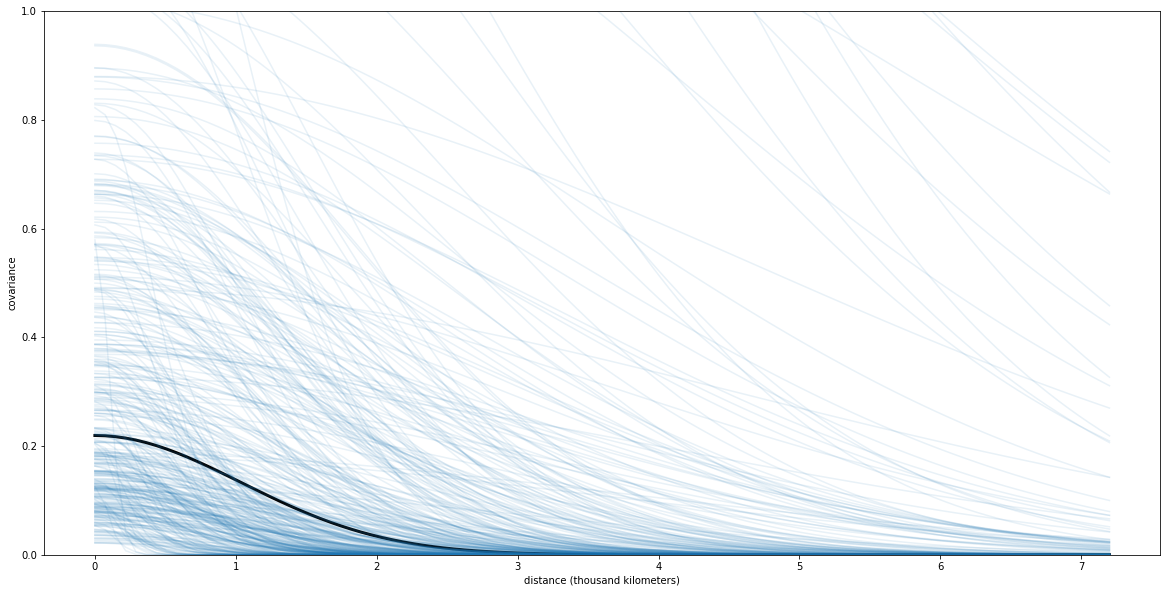

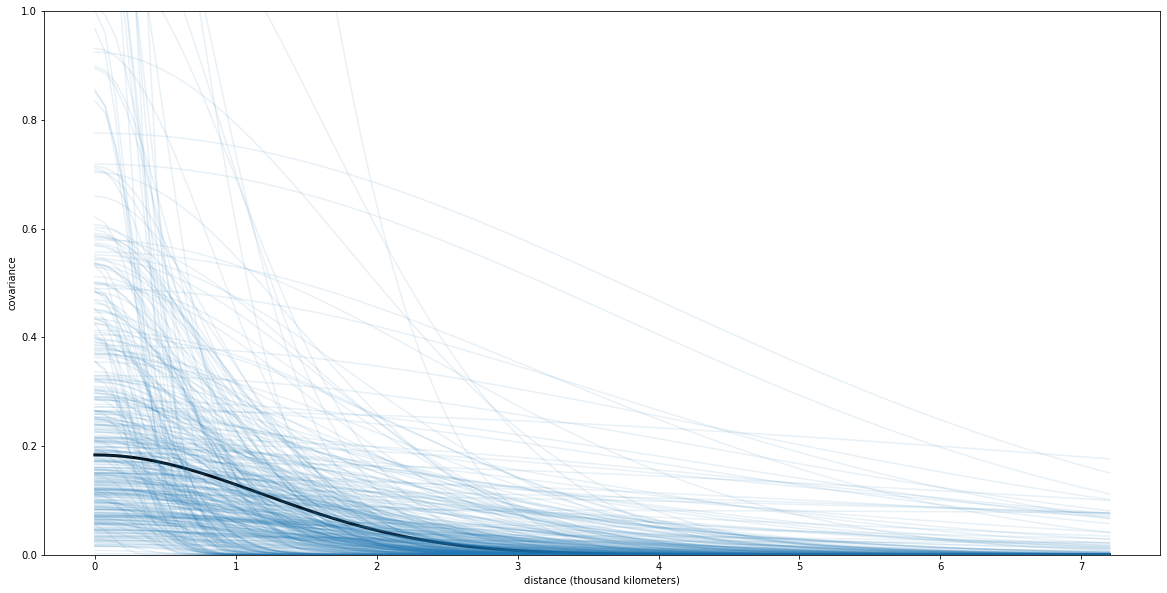

In [28]:
def plot_covariance_matrix(xs, trace):
    _, ax = plt.subplots()
    η2s = trace['η2']
    ρ2s = trace['ρ2']
    ax.plot(xs, np.median(η2s) * np.exp(-np.median(ρ2s) * xs ** 2), "black", lw=3)
    ax.plot(xs, (η2s[::20][:, None] * np.exp(-ρ2s[::20][:, None] * xs ** 2)).T, "C0", alpha=.1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('distance (thousand kilometers)')
    ax.set_ylabel('covariance')

xs = np.linspace(0, distances.max(), 100)
plot_covariance_matrix(xs, traces[0])
plt.show()
plot_covariance_matrix(xs, traces[1])
plt.show()

## Exercises

### 13H1

In [6]:
df = pd.read_csv("../external/rethinking/data/bangladesh.csv", sep=";")
print(f"Data contains {len(df)} samples")
# There is district 54, which leads to complications when using the
# district as an index.
df.district = df.district.apply(lambda i: i - 1 if i > 53 else i)
df.head()

Data contains 1934 samples


,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


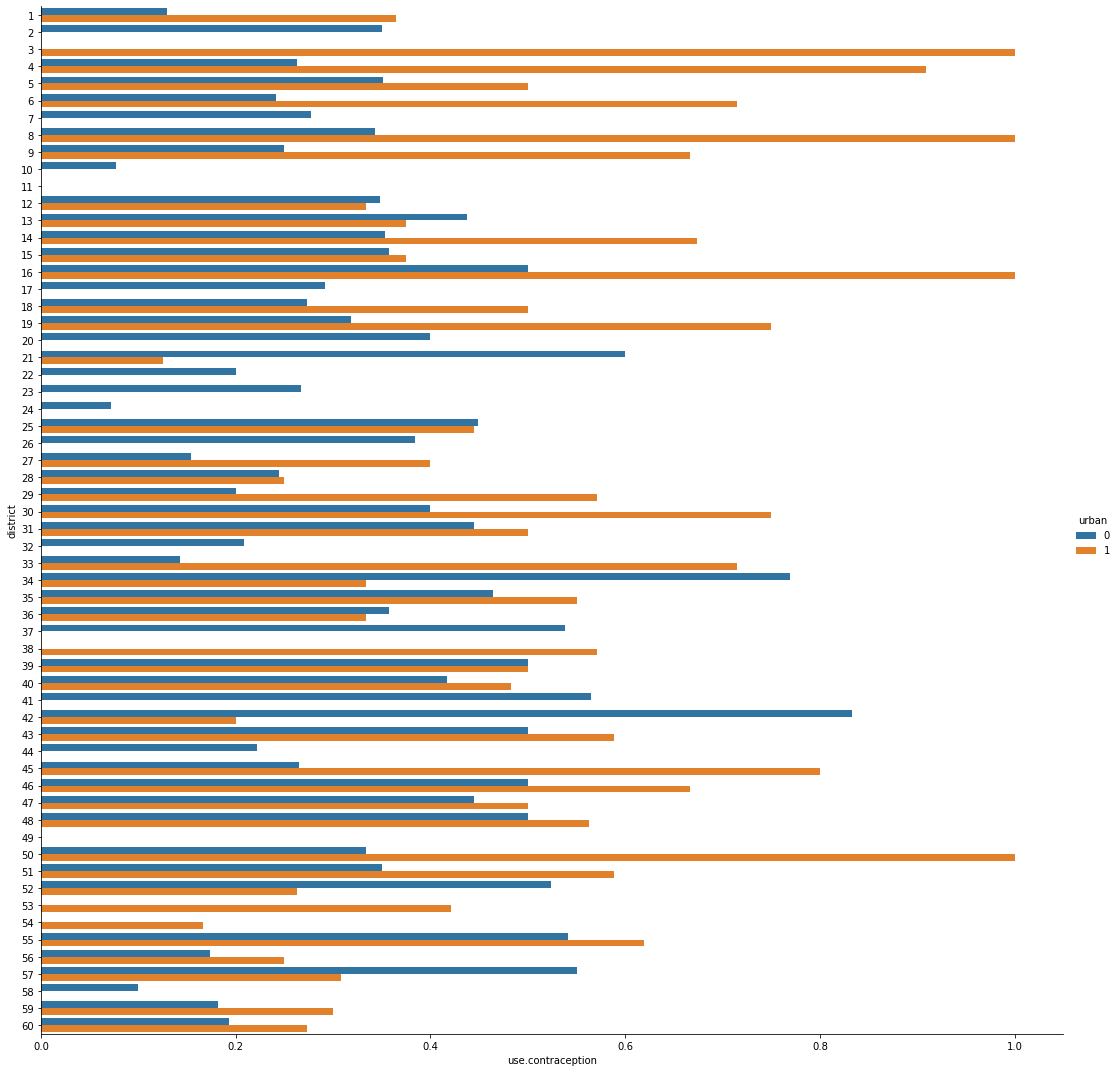

In [7]:
sns.catplot(y="district", x="use.contraception", hue="urban", data=df, kind="bar",
            orient="h", height=15, ci=None)

In [8]:
models = {}
traces = {}

In [9]:
district = df.district.values - 1
n_district = len(set(district))
use = df["use.contraception"].values
urban = df.urban.values
n_urban = len(set(urban))

if set(range(0, max(district) + 1)).difference(set(district)):
    print("Districts are not consecutive")

with pm.Model() as model:
    σ_district = pm.HalfCauchy.dist(beta=2.5)
    Σ_district_ = pm.LKJCholeskyCov("Σ_district_", n=2, eta=1, sd_dist=σ_district)
    Σ_district = pm.expand_packed_triangular(2, Σ_district_, lower=True)
    z_district = pm.Normal("z_district", mu=0, sigma=1, shape=(n_district, 2))
    α_district = pm.Deterministic("α_district", tt.dot(z_district, Σ_district.T))
    p = pm.math.invlogit(α_district[district, 0] + α_district[district, 1] * urban)
    pm.Binomial("y", 1, p, observed=use)
models[0] = model

In [10]:
kwargs = {"draws": 2000, "tune": 2000}
for (i, model) in models.items():
    if i not in traces:
        traces[i] = pm.sample(model=model, **kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_district, Σ_district_]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:58<00:00, 274.70draws/s]


In [11]:
az.summary(traces[0], var_names=["Σ_district_"])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Σ_district_[0],0.980,0.133,0.734,1.229,0.003,0.002,2446.0,2446.0,2455.0,4318.0,1.0
Σ_district_[1],-1.057,0.233,-1.518,-0.648,0.004,0.003,2878.0,2750.0,2984.0,3914.0,1.0
Σ_district_[2],0.549,0.151,0.288,0.846,0.003,0.002,3621.0,3584.0,3694.0,5163.0,1.0


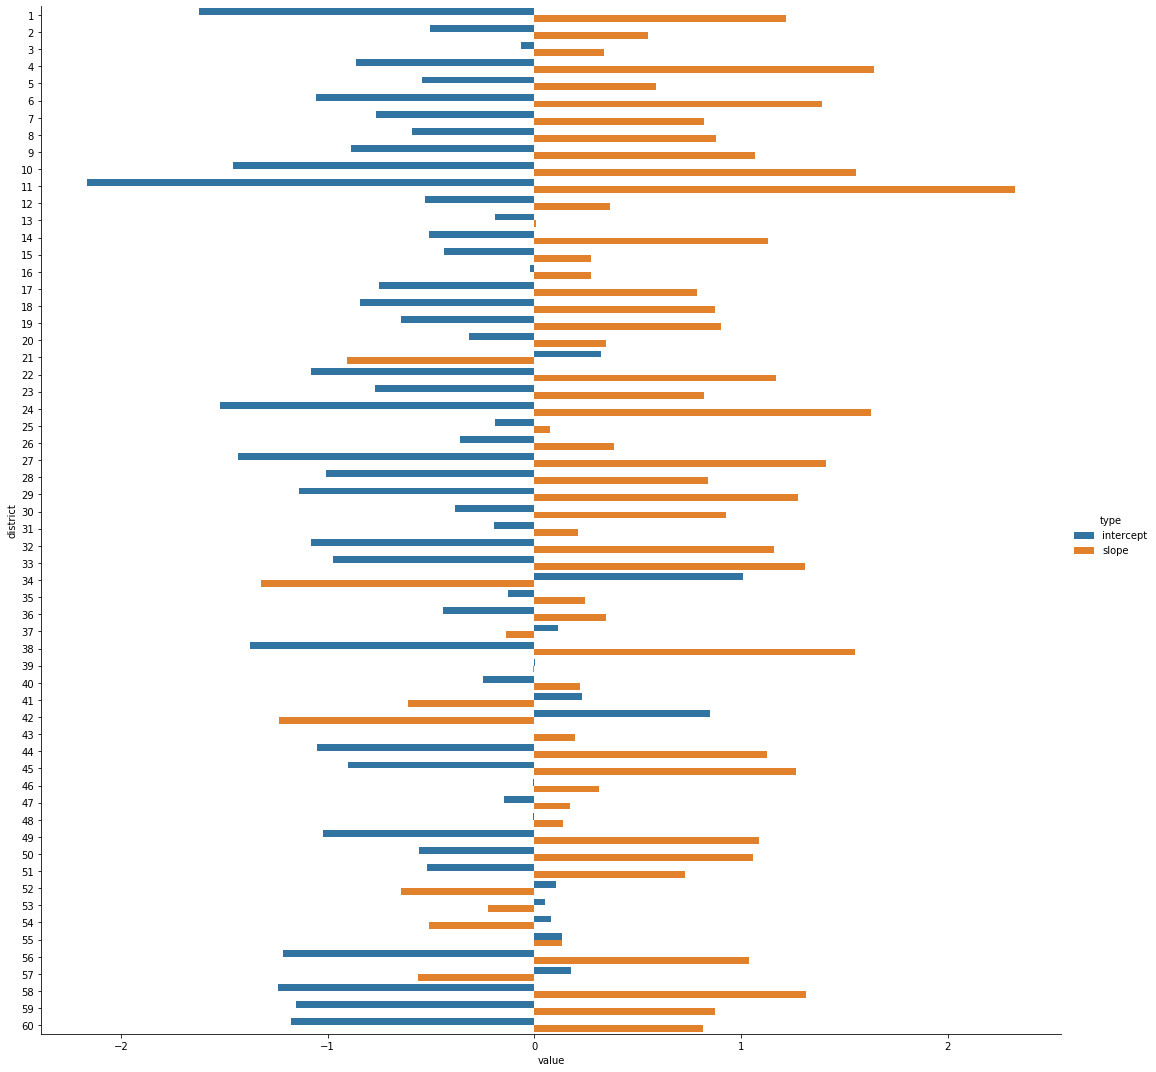

In [36]:
m = np.median(traces[0]["α_district"], axis=0)
intercepts = pd.DataFrame({"value": m[:, 0], "type": "intercept", "district": range(1, n_district + 1)})
slopes = pd.DataFrame({"value": m[:, 1], "type": "slope", "district": range(1, n_district + 1)})
df = pd.concat([intercepts, slopes], ignore_index=True)
sns.catplot(y="district", x="value", hue="type", data=df, kind="bar", orient="h", height=15, ci=None);

### 13H2

Data contains 234 samples


,Subject,age,height,Occasion
0,1,-1.0000,140.5,1
1,1,-0.7479,143.4,2
2,1,-0.4630,144.8,3
3,1,-0.1643,147.1,4
4,1,-0.0027,147.7,5


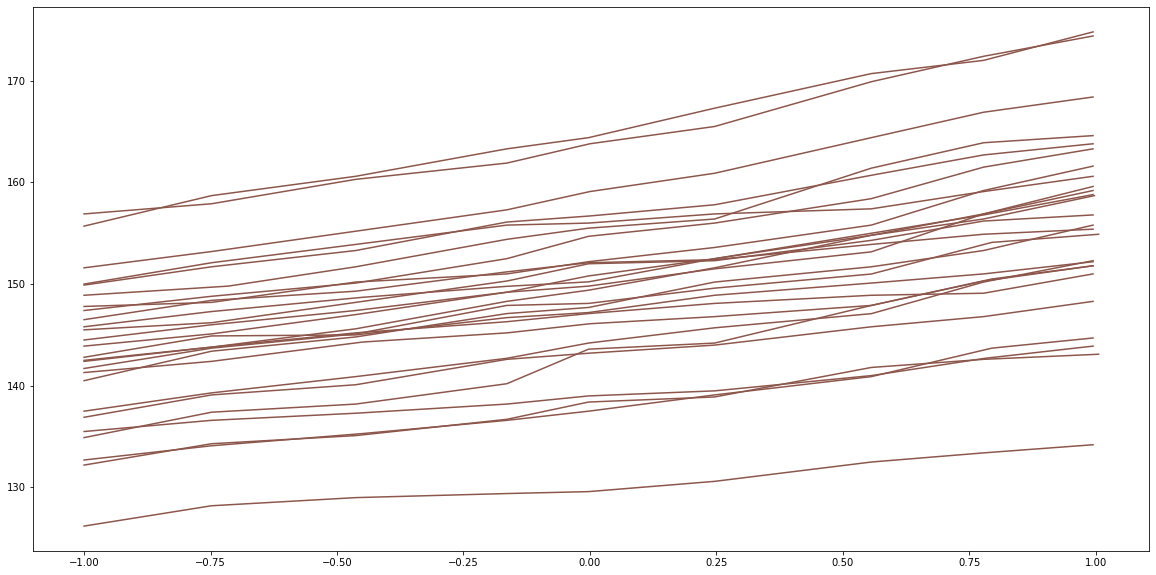

In [48]:
df = pd.read_csv("../external/rethinking/data/Oxboys.csv", sep=";")
print(f"Data contains {len(df)} samples")
display(df.head())
for (subject, data) in df.groupby("Subject"):
    plt.plot(data.age, data.height, f"C{i}", label=f"Subject {subject}")

In [149]:
models = {}
traces = {}

In [150]:
age = df.age.values
subject = df.Subject.values - 1
height = df.height.values
n_subject = len(set(subject))

if (d := set(range(n_subject)).difference(set(subject))):
    print(f"Subjects not consecutive: {d}")

with pm.Model() as model:
    σ_subject = pm.HalfCauchy.dist(beta=2.5)
    Σ_subject_ = pm.LKJCholeskyCov("Σ_subject_", n=2, eta=1, sd_dist=σ_subject)
    Σ_subject = pm.expand_packed_triangular(2, Σ_subject_, lower=True)
    z_subject = pm.Normal("z_subject", mu=0, sigma=1, shape=(n_subject, 2))
    α_subject = pm.Deterministic("α_subject", tt.dot(z_subject, Σ_subject.T))
    α0 = pm.Normal("α0", 150, 100)
    α1 = pm.Normal("α1", 0, 10)
    μ = (α0 + α_subject[subject, 0]) + (α1 + α_subject[subject, 1]) * age
    σ = pm.HalfNormal("σ", 1)
    pm.Normal("y", mu=μ, sigma=σ, observed=height)
models[0] = model

In [151]:
kwargs = {"draws": 2000, "tune": 1000, "target_accept": 0.9}
for (i, model) in models.items():
    if i not in traces:
        traces[i] = pm.sample(model=model, **kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, α1, α0, z_subject, Σ_subject_]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [03:03<00:00, 65.41draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [152]:
display(az.summary(traces[0], var_names=["α0", "α1", "α_subject"]))
display(az.summary(traces[0], var_names=["Σ_subject_"]))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α0,149.332,1.627,146.263,152.302,0.060,0.043,727.0,727.0,724.0,1319.0,1.01
α1,6.517,0.358,5.820,7.167,0.010,0.007,1197.0,1195.0,1195.0,1977.0,1.00
"α_subject[0,0]",-1.206,1.642,-4.329,1.777,0.061,0.043,735.0,735.0,732.0,1497.0,1.01
"α_subject[0,1]",0.607,0.476,-0.253,1.523,0.011,0.008,1969.0,1969.0,1968.0,3923.0,1.00
"α_subject[1,0]",-6.473,1.645,-9.466,-3.347,0.061,0.043,732.0,726.0,729.0,1401.0,1.01
"α_subject[1,1]",-1.058,0.479,-1.949,-0.144,0.011,0.008,1962.0,1962.0,1962.0,3936.0,1.00
"α_subject[2,0]",6.303,1.643,3.166,9.285,0.061,0.043,738.0,738.0,735.0,1426.0,1.01
"α_subject[2,1]",-1.589,0.480,-2.485,-0.683,0.011,0.007,2075.0,2075.0,2076.0,4082.0,1.00
"α_subject[3,0]",15.737,1.641,12.719,18.822,0.060,0.043,739.0,739.0,736.0,1322.0,1.01
"α_subject[3,1]",2.792,0.478,1.895,3.700,0.011,0.008,1897.0,1897.0,1897.0,3771.0,1.00


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Σ_subject_[0],8.249,1.193,6.201,10.517,0.035,0.024,1189.0,1189.0,1153.0,1924.0,1.0
Σ_subject_[1],1.029,0.323,0.416,1.614,0.008,0.006,1673.0,1656.0,1679.0,2601.0,1.0
Σ_subject_[2],1.372,0.217,0.984,1.773,0.005,0.004,1721.0,1721.0,1714.0,2848.0,1.0


### 13H3

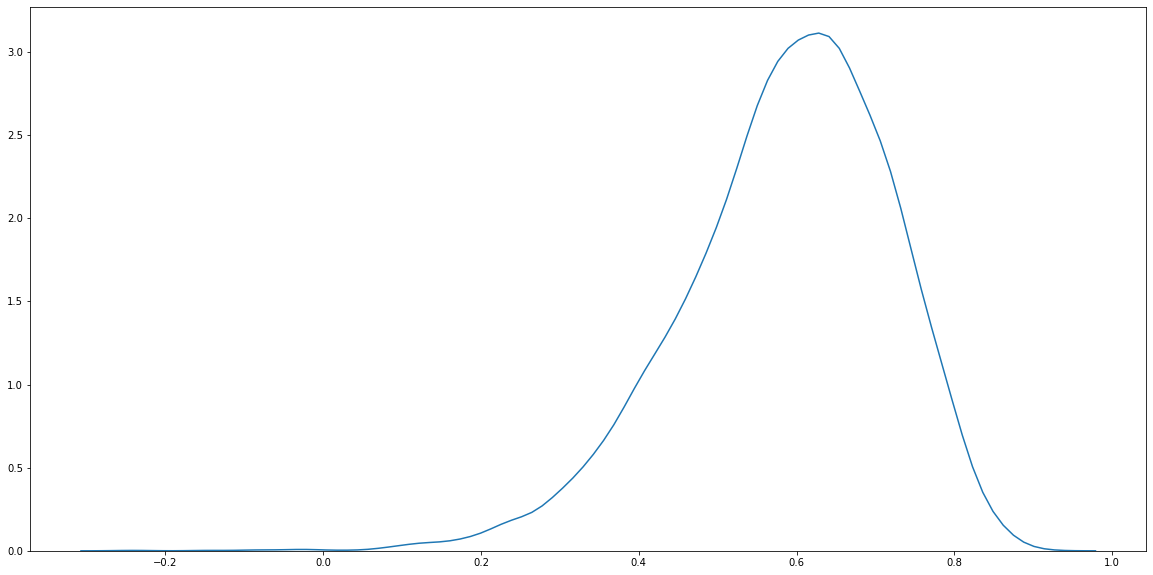

In [156]:
correlations = []
for packed in traces[0]["Σ_subject_"]:
    L = pm.math.expand_packed_triangular(2, packed, lower=True).eval()
    Σ = np.dot(L, L.T)
    correlations.append(Σ[0, 1] / np.sqrt(Σ[0, 0] * Σ[1, 1]))
sns.kdeplot(correlations)

### 13H4

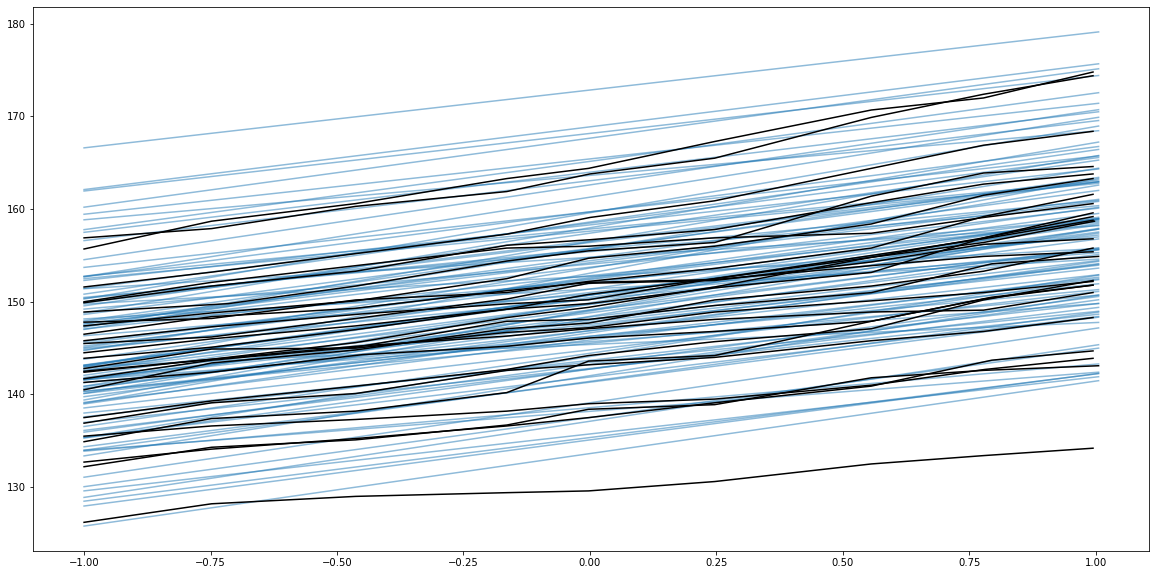

In [146]:
xs = np.linspace(np.min(age), np.max(age))
for i in range(100):
    packed = traces[0]["Σ_subject_"][i]
    L = pm.math.expand_packed_triangular(2, packed, lower=True)
    α0 = traces[0]["α0"][i]
    α1 = traces[0]["α1"][i]
    z = np.random.normal(0, 1, size=2)
    β = np.dot(z, L.eval())
    plt.plot(xs, α0 + β[0] + (β[1] + α1) * xs, "C0", alpha=0.5)
for (subject, data) in df.groupby("Subject"):
    plt.plot(data.age, data.height, "black")
plt.show()